In [4]:
#%pip install pandas
#%pip install tesseract

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pytesseract


from page_detection import cleaned_image
#import tensorflow as tf

# Extracting Words

### Load Image

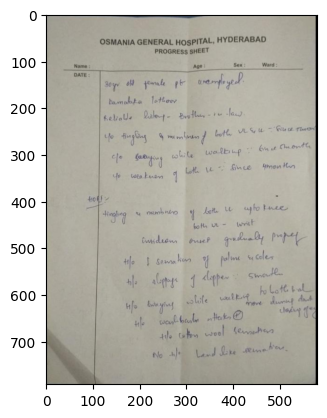

In [3]:
file_ = "Patient_Records/Arthritis/A_0001.jpeg"
imge = cleaned_image(file = file_)
gray = cv2.cvtColor(imge, cv2.COLOR_BGR2GRAY) #Convert to grayscale to use tesseract
plt.imshow(imge);

### Using Default Tesseract

In [4]:
extracted_text = pytesseract.image_to_string(gray)
print(extracted_text)

OSMANIA GENERAL HosPITAL, HYDERABAD
PROGRESS SHEET

Name Age Sex Ware
DATE =

Boyv od 4emale pl Uverrrpl Hh.
v f Md

bamobta lotto

febrale

Lote W

Sines oanbnio y
Bi) Ge ve= wel
waded Propet,

fideo evseh Ff

fief semmbion af fol Sele

[> alegrys 4 “ate Smee

ieee fo Lott: bol
fo bweyiny lite eve dumng dat
leky |

ube woul bcasba take @
le hw wool Sevehar

Breu,

No: 4] Melled Shales




#### Extracting ROI (Regions of Interest)

Useful for scenic text detection

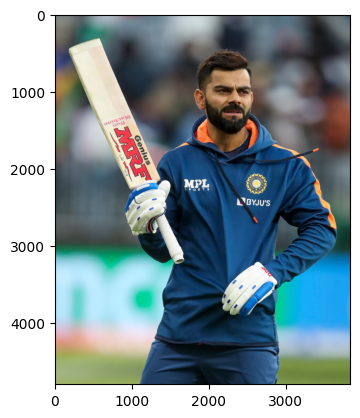

In [28]:
img = cv2.cvtColor(cv2.imread("Sample/kohli.jpeg"),cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [29]:
def predictions(scores,geometry, minConf = 0.3):
    r,c = scores.shape[2:4]
    boxes =[]
    confidences =[]
    
    for y in range(r):
        # Create temporary box (= coordinates that surround text)
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        
        for x in range(c):
            # Grab the confidence score for the current detection for each column and continue if there is micConf
            score = float(scoresData[x])
            if score < minConf:
                continue
            #print(score)
            offsetX = x*4
            offsetY = y*4
            
            # Compute the boundary rectangle using angle and offset
            angle = anglesData[x]
            cos,sin = np.cos(angle), np.sin(angle)
            
            curr_height = xData0[x]+xData2[x]
            curr_width = xData1[x]+xData3[x]
            # Compute the offset factor as our resulting feature
            offset = ([
                offsetX + (cos * xData1[x]) + (sin * xData2[x]),
                offsetY - (sin * xData1[x]) + (cos * xData2[x])
                ])
            
            topL= (-sin*curr_height+offset[0],-cos*curr_height + offset[1])
            botR= (-cos*curr_width+offset[0],sin*curr_width+ offset[1])
            
            cX = 0.5 * (topL[0] + botR[0])
            cY = 0.5 * (topL[1] + botR[1])
            box = ((cX, cY), (curr_width, curr_height), -1 * angle * 180.0 / np.pi)
            
            #Store the rectangle and confidence
            boxes.append(box)
            confidences.append(score)
            
    return (boxes, confidences)


In [30]:

def localize(image,east,nms=0.3):
    origH,origW = image.shape[:2]
    #newW, newH = near32(origW),near32(origH)
    newW,newH = 320,320
    rW,rH = origW/float(newW),origH/float(newH)
    net = cv2.dnn.readNet(east)
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    
    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]
    
    scores, geometry = net.forward(layerNames)
    rects, confidences = predictions(scores, geometry)
    
    idxs = cv2.dnn.NMSBoxesRotated(rects,scores= confidences,score_threshold=0.6,nms_threshold=nms)

    if len(idxs) > 0:

        for i in idxs.flatten():
            box = cv2.boxPoints(rects[i])
            box[:, 0] *= rW
            box[:, 1] *= rH
            box = np.intp(box)
            
            t=int(0.005*origH)
            cv2.polylines(image, [box], True, (0, 255, 0), t if t else 2)
    
    return image

Sample Usage on Scenic Image

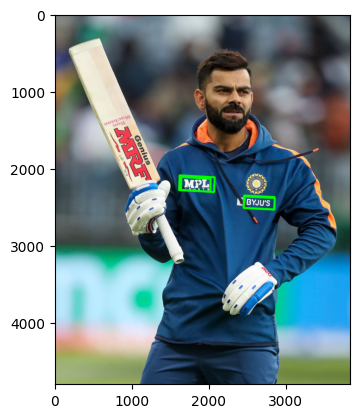

In [31]:
img1 = localize(img,east = "frozen_east_text_detection.pb")
plt.imshow(img1);

In [51]:
def detect_localized_text(image,east,nms=0.4,padding = 0):
    origH,origW = image.shape[:2]
    newW,newH = 640,640
    rW,rH = origW/float(newW),origH/float(newH)
    net = cv2.dnn.readNet(east)
    words=[]
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]
    
    scores, geometry = net.forward(layerNames)
    rects, confidences = predictions(scores, geometry)
    
    idxs = cv2.dnn.NMSBoxesRotated(rects,scores= confidences,score_threshold=0.4,nms_threshold=nms)

    results=[]
    for i in idxs.flatten():
        box = cv2.boxPoints(rects[i])
        box[:, 0] *= rW
        box[:, 1] *= rH
        box = np.intp(box)
        
        (x, y, w, h) = cv2.boundingRect(box)
        
        #Enable padding for obtaining better results
        dX = int(w*padding)
        dY = int(h*padding)
        
        startX = max(0, x - dX)
        startY = max(0, y - dY)
        endX=min(origW,x+w+(dX*2))
        endY=min(origH,y+h+(dY*2))
        
        paddedROI = image[startY:endY, startX:endX]
        
        options = "--psm 7"
        text = pytesseract.image_to_string(paddedROI, config=options)
        
        results.append((box, text))
        words.append(text.strip())
        
    results = sorted(results, key=lambda x: x[0][0][0])
    for (box, text) in results:
        # print("{}\n".format(text))
        output = image.copy()
        cv2.polylines(output, [box], True, (0, 255, 0), 2)
        
        (x, y, w, h) = cv2.boundingRect(box)
        cv2.putText(output, text, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 0, 255), 3)
    
    return words
    

In [1]:
text_from_roi= detect_localized_text(img,east="frozen_east_text_detection.pb")
text_from_roi

NameError: name 'detect_localized_text' is not defined